In [62]:
import numpy as np
import hist
import matplotlib.pyplot as plt
import mplhep as hep
import pickle
import lz4.frame
from wremnants import plot_tools

In [64]:
%load_ext autoreload
%autoreload 2

In [56]:
with lz4.frame.open("/home/k/kelong/work/WRemnants/w_z_gen_dists.pkl.lz4") as minnlof:
    minnlo = pickle.load(minnlof)
minnloh = minnlo["ZmumuPostVFP"]["output"]["nominal_gen"]*minnlo["ZmumuPostVFP"]["dataset"]["xsec"]/minnlo["ZmumuPostVFP"]["weight_sum"]

In [3]:
f = np.load("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/Ztests/inclusive_Z_pT.npz", allow_pickle=True)

In [16]:
var_axis = hist.axis.Integer(f["bins"][0][0], f["bins"][0][-1], name="vars")
mass_axis = hist.axis.Variable(f["bins"][1], name="mass")
y_axis = hist.axis.Variable(f["bins"][2], name="y")
#pt_axis = hist.axis.Variable(f["bins"][3], name="pt")
pt_axis = minnloh.axes["ptVgen"]

In [17]:
scetlibh = hist.Hist(var_axis,mass_axis,y_axis,pt_axis, storage=hist.storage.Weight())

In [20]:
scetlibh[...,:40] = np.stack((f["hist"], f["hist_err"]), axis=-1)

In [57]:
minnloh

Hist(
  Regular(12, 60, 120, name='massVgen', label='massVgen'),
  Variable([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 10], name='absYVgen', label='absYVgen'),
  Variable(array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  45.,  50.,  55.,
        60.,  75., 100.]), name='ptVgen', label='ptVgen'),
  Integer(0, 1, underflow=False, overflow=False, name='chargeVgen', label='chargeVgen'),
  storage=Weight()) # Sum: WeightedSum(value=1870.37, variance=0.059025) (WeightedSum(value=1976.1, variance=0.0622546) with flow)

In [45]:
minnlo["ZmumuPostVFP"]["output"]["nominal_gen"].sum()

WeightedSum(value=8.44125e+07, variance=8.44125e+07)

In [51]:
x = minnlo["ZmumuPostVFP"]["output"]["nominal_gen"].sum()

In [53]:
x.value/minnlo["ZmumuPostVFP"]["weight_sum"]

1.1295678198765564

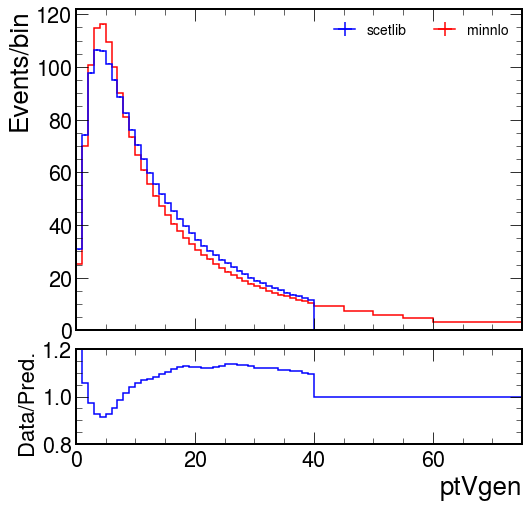

In [67]:
fig = plot_tools.makePlotWithRatioToRef([minnloh.project("ptVgen"), scetlibh.project("ptVgen")], colors=["red", "blue"], labels=["minnlo", "scetlib"], rrange=[0.8, 1.2], binwnorm=1.)


In [84]:
from scipy import special

In [177]:
mid = 25
k=0.2

In [182]:
corr = np.ones(len(pt_axis.edges)+1)
corr[1:] = 0.5*(1-special.erf(k*(pt_axis.edges-mid)))

In [184]:
corr

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 9.99999999e-01, 9.99999992e-01, 9.99999961e-01,
       9.99999822e-01, 9.99999239e-01, 9.99996987e-01, 9.99988955e-01,
       9.99962493e-01, 9.99881983e-01, 9.99655743e-01, 9.99068577e-01,
       9.97661133e-01, 9.94545251e-01, 9.88174192e-01, 9.76142560e-01,
       9.55156989e-01, 9.21350396e-01, 8.71050482e-01, 8.01928045e-01,
       7.14196178e-01, 6.11351295e-01, 5.00000000e-01, 3.88648705e-01,
       2.85803822e-01, 1.98071955e-01, 1.28949518e-01, 7.86496035e-02,
       4.48430109e-02, 2.38574401e-02, 1.18258083e-02, 5.45474918e-03,
       2.33886749e-03, 9.31423149e-04, 3.44256948e-04, 1.18017208e-04,
       3.75065973e-05, 1.10452485e-05, 7.70862896e-09, 7.68718422e-13,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fa1b7e782e0>, errorbar=None, legend_artist=None)]

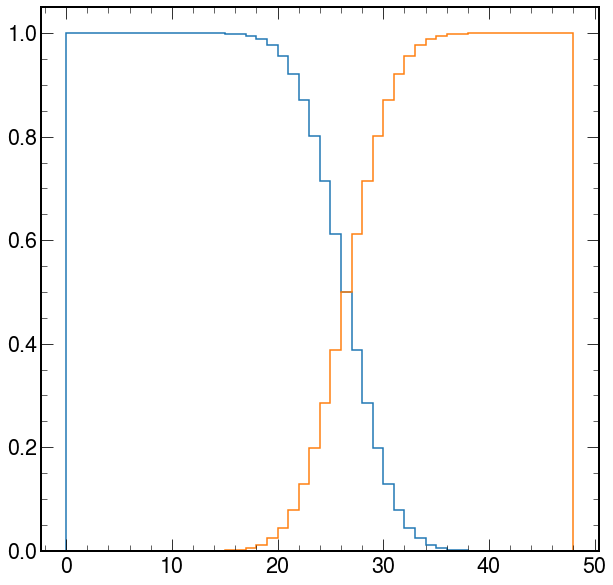

In [185]:
hep.histplot(corr)
hep.histplot(1-corr)

In [189]:
scetlibh.shape

(1, 1, 1, 46)

In [190]:
minnlocorr[...] = minnloh.view(flow=True)*(1-corr[np.newaxis,np.newaxis,:,np.newaxis,])
scetlibcorr = scetlibh*corr[np.newaxis,np.newaxis,np.newaxis,1:-1]

In [191]:
corrh_pt = scetlibcorr.project("ptVgen")+minnlocorr.project("ptVgen")

In [202]:
hists = [corrh_pt] + [x .project("ptVgen") for x in [minnloh, scetlibh, minnlocorr, scetlibcorr]]
labels = [r"MiNNLO$\bigoplus$SCETlib", "MiNNLO", "SCETlib", "MiNNLO turnon", "SCETlib turnoff"]
colors = ["blue", "orange", "purple", "red", "green"]

In [ ]:
fig = plot_tools.makePlotWithRatioToRef(hists, colors=colors, labels=labels, rrange=[0.8, 1.2], binwnorm=1., rlabel="x/MiNNO+Stlib")